#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 50.

Нам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Вывод:" data-toc-modified-id="Вывод:-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод:</a></span></li></ul></div>

## Подготовка

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
df = pd.read_csv('/Users/alex/Desktop/питон/тетрадки jupiter notebook/Проект по временным рядам/taxi.csv', index_col=[0], parse_dates=[0])



In [2]:
#ознакомимся с датасетом
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


AxesSubplot(0.125,0.125;0.775x0.755)


num_orders    13.0
dtype: float64

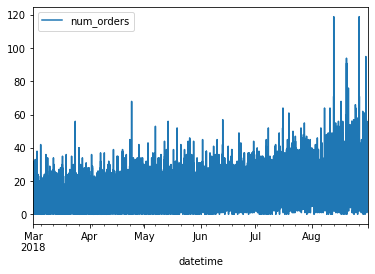

In [3]:
#посмотрим распределение значений 
print(df.plot(ax=plt.gca()))
df.value_counts().head(50)
df.median()

## Анализ

In [4]:
#Проведем тест Дикки-Фуллера на исходном датасете
test = adfuller(df['num_orders'])
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values:')
for key,value in test[4].items():
    print('\t{}: {:.4f}'.format(key, value))
if test[0] > test[4]['5%']:
    print('Есть единичные корни, ряд не стационарен')
else:
    print('Единичных корней нет, ряд стационарен')

adf:  -12.548885000267536
p-value:  2.2286378815480428e-23
Critical values:
	1%: -3.4306
	5%: -2.8616
	10%: -2.5668
Единичных корней нет, ряд стационарен


AxesSubplot(0.125,0.125;0.775x0.755)


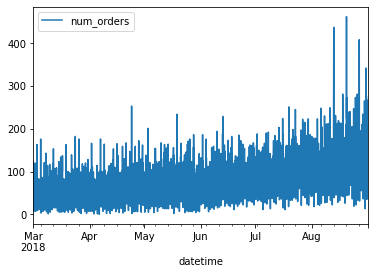

In [5]:
#разложим временной ряд на временные промежутки в 1 час, все значения выпавшие на этот час суммируем
df.sort_index(inplace=True)

df = df.resample('1H').sum()
print(df.plot())

<AxesSubplot:xlabel='datetime'>

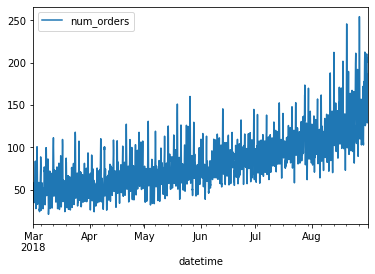

In [6]:
#выведем скользящее среднее для всего датасета
df.rolling(7).mean().plot(ax=plt.gca())

In [7]:
#произведем декомпозицию датасета и вычленим тренд сезонность и остатки
decomposition = seasonal_decompose(df)
#Сезонность возьмем чуть больше чем за день, что бы посмотреть как меняется количество заказов в течении дня
season_daily = decomposition.seasonal[-24:]
#Сезонность недельная
season_weekly = decomposition.seasonal[-24*7:]
#тренд выведем за последние два месяца, чтобы отследить как меняется среднее количество заказов
trend = decomposition.trend[-1488:]
#ну и остатки просто так для практики выведем 
resid = decomposition.resid



(array([17591., 17622., 17652., 17683., 17713., 17744., 17775.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

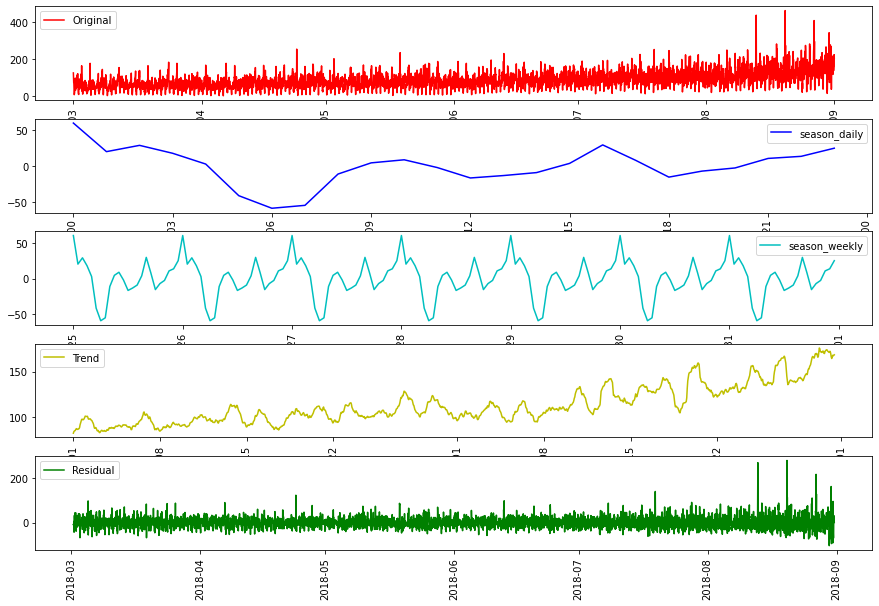

In [8]:
# визуализируем полученные выше сущности
plt.figure(figsize=(15,10))
plt.subplot(511)
plt.plot(df, label='Original', color='r')
plt.legend()
plt.xticks(rotation=90)
plt.subplot(512)
plt.plot(season_daily, label='season_daily', color='b')
plt.legend()
plt.xticks(rotation=90)
plt.subplot(513)
plt.plot(season_weekly, label='season_weekly', color='c')
plt.legend()
plt.xticks(rotation=90)
plt.subplot(514)
plt.plot(trend, label='Trend', color='y')
plt.legend()
plt.xticks(rotation=90)
plt.subplot(515)
plt.plot(resid, label='Residual', color='g')
plt.legend()
plt.xticks(rotation=90)


Наблюдается тренд на увеличение колличества заказов, что указывает на нестационарность ряда. При использовании продвинутых моделей прогнозирования временных рядов типа ARIMA это было бы критичным, но для прогнозирования линейной регрессией делать ряд стационарнее нам не требуется.

In [9]:
#Проведем тест Дикки-Фуллера на ресемплированном датасете
test = adfuller(df['num_orders'])
print('adf: ', test[0])
print('p-value: ', test[1])
print('Critical values:')
for key,value in test[4].items():
    print('\t{}: {:.4f}'.format(key, value))
if test[0] > test[4]['5%']:
    print('Есть единичные корни, ряд не стационарен')
else:
    print('Единичных корней нет, ряд стационарен')
    

adf:  -3.068924289027951
p-value:  0.028940051402613316
Critical values:
	1%: -3.4318
	5%: -2.8622
	10%: -2.5671
Единичных корней нет, ряд стационарен


## Обучение

Создадим новые фичи для будущего обучения

In [10]:
#Фичи временные
df['dayofweek'] = df.index.dayofweek
df['month'] = df.index.month
df['hour'] = df.index.hour

df.head()

,num_orders,dayofweek,month,hour
datetime,,,,
2018-03-01 00:00:00,124,3,3,0
2018-03-01 01:00:00,85,3,3,1
2018-03-01 02:00:00,71,3,3,2
2018-03-01 03:00:00,66,3,3,3
2018-03-01 04:00:00,43,3,3,4


In [11]:
max_lag = 4

In [12]:
#лаги
for lag in range(1, max_lag+1, 1):
    df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

In [13]:
#Скользящее среднее с окном равным 4
df['rolling_mean'] = df['num_orders'] \
.shift() \
.rolling(4) \
.mean()

df.head()

,num_orders,dayofweek,month,hour,lag_1,lag_2,lag_3,lag_4,rolling_mean
datetime,,,,,,,,,
2018-03-01 00:00:00,124,3,3,0,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,3,1,124.0,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,3,2,85.0,124.0,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,3,71.0,85.0,124.0,NaN,NaN
2018-03-01 04:00:00,43,3,3,4,66.0,71.0,85.0,124.0,86.5


ну всё, фичи готовы, можно начинать в МЛ

In [14]:
#выделим таргет, фичи и тест с трейном без перемешивания
train,test = train_test_split(df, shuffle=False, test_size=.10)
train = train.dropna()
test = test.dropna()

features_train = train.drop('num_orders', axis=1)
target_train = train['num_orders']
features_test = test.drop('num_orders', axis=1)
target_test = test['num_orders']



**Предсказывать будем линейной регрессией и лесом регрессий**

In [15]:
#Обучим линейную регрессию
lin_reg= LinearRegression()
lin_reg.fit(features_train, target_train)

LinearRegression()

In [16]:
#обучим лес регрессий с подбором гиперпараметров рандомайзд сечем с отбором по rmse и специальной кросс-валидацией для временных рядов
RFR_model = RandomForestRegressor()
params={'n_estimators':range(1,101,5), 
        'max_depth':range(1,50,5)}
tscv = TimeSeriesSplit(n_splits=10)
rand_search = RandomizedSearchCV(estimator=RFR_model, param_distributions=params, scoring='neg_root_mean_squared_error', cv=tscv, n_jobs=-1, verbose=1, random_state=12)
rand_search.fit(features_train, target_train)
print(f'RandomForestRegressor best_params - {rand_search.best_params_}, best_score - {rand_search.best_score_}')

Fitting 10 folds for each of 10 candidates, totalling 100 fits
RandomForestRegressor best_params - {'n_estimators': 61, 'max_depth': 41}, best_score - -24.124702605531812


Всё готово, можно предсказывать и смотреть метрику

## Тестирование

In [17]:
#посмотрим метрику линейной регрессии на тестовой выборке
predictions_lin_test = lin_reg.predict(features_test)
print(f'RMSE for LinearRegression on test data - {mean_squared_error(target_test, predictions_lin_test)**0.5}')


RMSE for LinearRegression on test data - 53.59548800706723


In [18]:
#посмотрим метрику случайного леса на тестовой выборке
RFR_model = RandomForestRegressor(n_estimators = 61, max_depth = 41, random_state = 12)
RFR_model.fit(features_train, target_train)
prediction_rfr_test = RFR_model.predict(features_test)
print(f'RMSE for RandomForestRegressor on test data - {mean_squared_error(target_test, prediction_rfr_test)**0.5}')

RMSE for RandomForestRegressor on test data - 48.08217088102515


RandomForestRegressor - дал метрику лучше линейной регрессии, отрисуем его точность на графике:

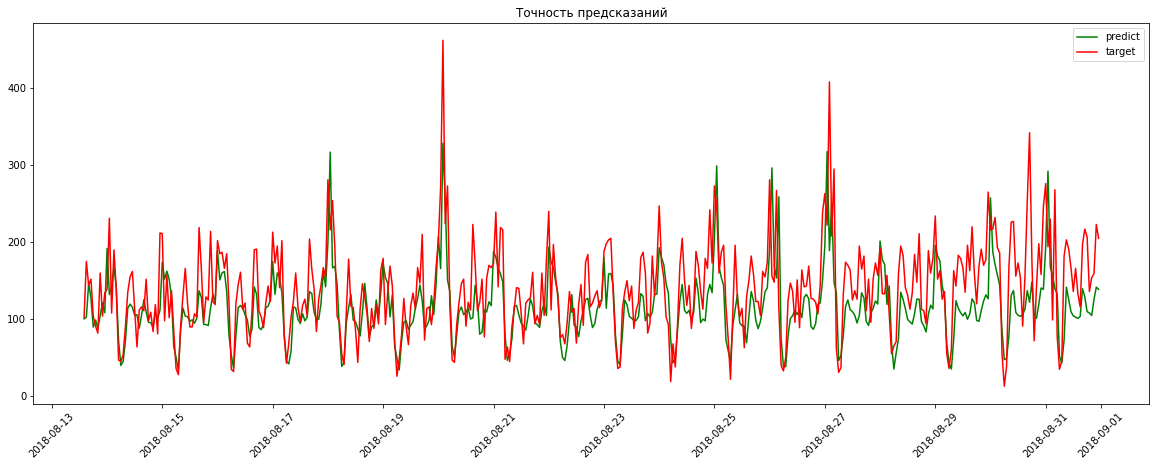

In [19]:
#Отобразим графически точность нашего предсказания
predict = pd.DataFrame(prediction_rfr_test, index=target_test.index)
plt.figure(figsize=(20,7))

plt.plot(predict, label='predict', color='g')
plt.xticks(rotation=45)

plt.plot(target_test, label='target', color='r')
plt.xticks(rotation=45)
plt.legend()
plt.title('Точность предсказаний')
plt.show()


## Вывод: 
Случайный лес дал метрику удовлетворяющую требованию заказчика, в продакшн соответственно рекомендуем брать именно его.